In [309]:
%matplotlib inline

In [310]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy

In [311]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of frames
#

frames = []

for file in os.listdir("Data"):
    if file.endswith(".gbgout"):
        filepath = os.path.join("Data/", file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))

In [312]:
#
# This combines all of the individual frames into one dataframe, combining on the "Gene" column
#

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)

In [313]:
#
# Sort columns by name
#

df = df.reindex_axis(sorted(df.columns), axis=1)

In [314]:
#
# Use only genes starting with "Y" which are protein-coding genes
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [315]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [316]:
# Save

df.to_csv("Barton_combined_Ygenes.txt", sep='\t')

The paper discusses problems with individual samples. One way to screen for this in a sample that's so large is to look within the two sets for outliars.

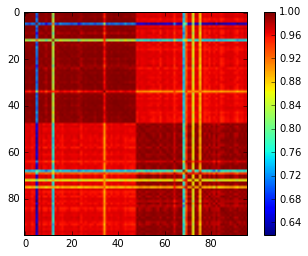

In [317]:
colnames = df.columns.get_values()

corrdata = np.zeros( (len(colnames),len(colnames)))

for i1,c1 in enumerate(colnames):
    d = []
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]
        
plt.imshow(corrdata)
plt.colorbar()

Can see from plot about that there are several problematic samples that have correlations that are outliars. How should we filter them? Simplest way would be to pick an average correlation to other samples as a cutoff. What should we choose? 

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   2.,  89.]),
 array([ 0.5  ,  0.525,  0.55 ,  0.575,  0.6  ,  0.625,  0.65 ,  0.675,
         0.7  ,  0.725,  0.75 ,  0.775,  0.8  ,  0.825,  0.85 ,  0.875,
         0.9  ,  0.925,  0.95 ,  0.975]),
 <a list of 19 Patch objects>)

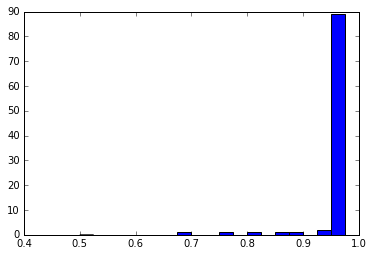

In [318]:
#
# Make a histogram of average correlation values
#

corrmeans = []
for i1,c1 in enumerate(corrdata):
    corrmeans.append(np.mean(c1))

plt.hist(corrmeans, bins=np.arange(0.5,1.0,.025))

Most are above .95 so let's make that our cutoff

In [319]:
colnames_filt = []
for c1 in colnames:
    d = []
    for c2 in colnames:
        d.append(pearsonr(df[c1],df[c2])[0])
    d = np.array(d)
    if np.mean(d) < 0.95:
        print ("Removing ",c1,np.mean(d))
    else:
        colnames_filt.append(c1)
        
colnames = colnames_filt

Removing  Snf2_rep06 0.691487784223
Removing  Snf2_rep13 0.803427905697
Removing  Snf2_rep35 0.932471392569
Removing  WT_rep21 0.764104671143
Removing  WT_rep22 0.933839516889
Removing  WT_rep25 0.86363576014
Removing  WT_rep28 0.891720439048


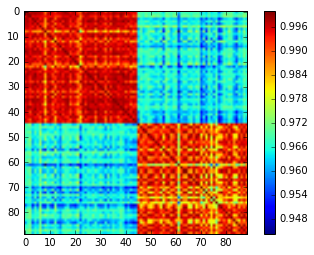

In [320]:
# now replot 

corrdata = np.zeros( (len(colnames),len(colnames)))

for i1,c1 in enumerate(colnames):
    d = []
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]
        
plt.imshow(corrdata)
plt.colorbar()

Still some heterogeneity but looks a lot better - no egregious outliars - so we'll use this set

In [321]:
# now create lists for WT and Snf2

colnames_snf2 = []
colnames_WT = []

for c in colnames:
    if c.startswith("Snf2"):
        colnames_snf2.append(c)
    elif c.startswith("WT"):
        colnames_WT.append(c)

In [322]:
# create new columns that are averages

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)

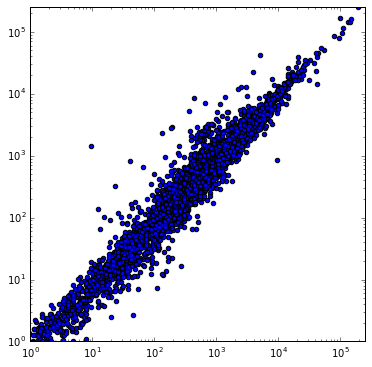

In [323]:
maxval = max(np.max(df['Snf2_ave']),np.max(df['WT_ave']))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(df['Snf2_ave'],df['WT_ave'])

Slope is  [ 0.96931492]


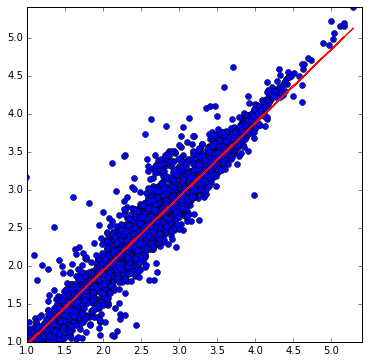

In [201]:
# how well do these fit?

c1 = 'Snf2_ave'
c2 = 'WT_ave'

# remove too small values

x = np.log10(df[c1][(df[c1] > 1) & (df[c2] > 1)])
y = np.log10(df[c2][(df[c1] > 1) & (df[c2] > 1)])

maxval = max(np.max(x),np.max(y))

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x,y)

print ("Slope is ", a)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)

ax.plot(x, y, 'bo')
ax.plot(x, a*x, 'r-')


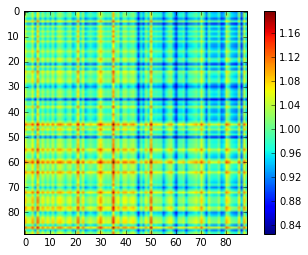

In [324]:
l = len(colnames)

corrdata = np.zeros((l,l))

for i1, c1 in enumerate(colnames):
    d = []
    for i2, c2 in enumerate(colnames):
        x = np.log10(df[c1][(df[c1] > 1) & (df[c2] > 1)])
        y = np.log10(df[c2][(df[c1] > 1) & (df[c2] > 1)])

        x = x[:,np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, y)

        corrdata[i1][i2] = a
plt.imshow(corrdata)
plt.colorbar()

Slope is  [ 0.97851688]


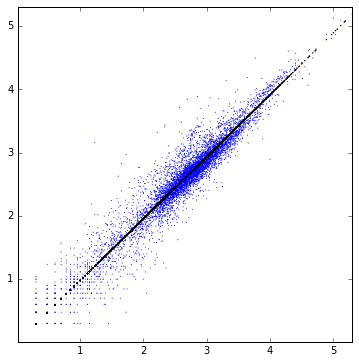

In [396]:
# let's pick a pair of WT and snf2 experiments and see how they compare

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# how well do these fit?

# remove too small values

x = np.log10(df[c1][(df[c1] > 1) & (df[c2] > 1)])
y = np.log10(df[c2][(df[c1] > 1) & (df[c2] > 1)])

maxval = max(np.max(x),np.max(y))

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x,y)

print ("Slope is ", a)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(.01,maxval)
ax.set_ylim(.01,maxval)

ax.scatter(x, y, s = 1, c='b', edgecolor = 'none')
ax.scatter(x, a*x, c='black',s = 2, edgecolor='none')


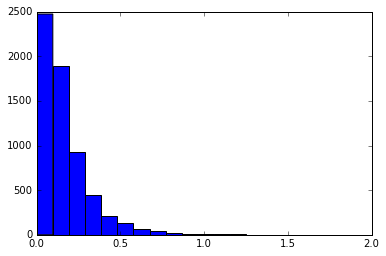

In [388]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# remove too small values

x = np.log10(df[c1][(df[c1] > 1) & (df[c2] > 1)])
y = np.log10(df[c2][(df[c1] > 1) & (df[c2] > 1)])

d = []

for i,vx in enumerate(x):
    d.append(abs(x[i]-y[i]))

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1)
hist = ax.hist(d,bins=20) 


Slope is  [ 0.87765606]


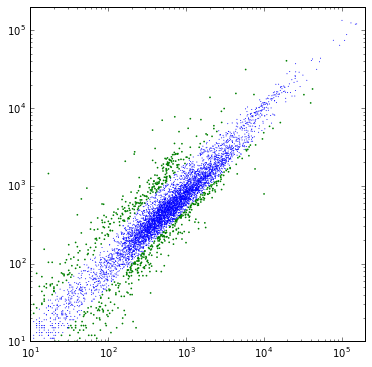

In [408]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# remove too small values

x = df[c1][(df[c1] > 1) & (df[c2] > 1)]
y = df[c2][(df[c1] > 1) & (df[c2] > 1)]

maxval = max(np.max(x),np.max(y))

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x,y)

print ("Slope is ", a)

c = []
s = []

for i,vx in enumerate(x):
    if x[i] * y[i] > 0:
        if abs(np.log2(x[i]/y[i])) > 1:
            c.append('g')
            s.append(3)
        elif abs(np.log2(x[i]/y[i])) > .5:
            c.append('b')
            s.append(1)
        else:
            c.append('b')
            s.append(1)
    else:
        c.append('k')
        s.append(1)
    

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(10,maxval)
ax.set_ylim(10,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = s, c=c, edgecolor = 'none')
#ax.scatter(x, a*x, c='black',s = , edgecolor='none')


Slope is  [ 1.08359576]


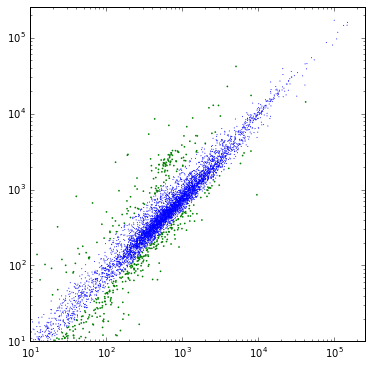

In [409]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_ave'
c2 = 'WT_ave'

# remove too small values

x = df[c1][(df[c1] > 1) & (df[c2] > 1)]
y = df[c2][(df[c1] > 1) & (df[c2] > 1)]

maxval = max(np.max(x),np.max(y))

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x,y)

print ("Slope is ", a)

c = []
s = []

for i,vx in enumerate(x):
    if x[i] * y[i] > 0:
        if abs(np.log2(x[i]/y[i])) > 1:
            c.append('g')
            s.append(3)
        elif abs(np.log2(x[i]/y[i])) > .5:
            c.append('b')
            s.append(1)
        else:
            c.append('b')
            s.append(1)
    else:
        c.append('k')
        s.append(1)
    

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(10,maxval)
ax.set_ylim(10,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = s, c=c, edgecolor = 'none')
#ax.scatter(x, a*x, c='black',s = , edgecolor='none')


In [366]:
# calculate kolmogorov-smirnov stat on WT vs SNF2

ksv = {}

for index, row in df.iterrows():
    snf2 = row[colnames_snf2]
    wt = row[colnames_WT]
    ksv[index] = ks_2samp(wt,snf2)[1]

In [367]:
# sort genes by ks value

ksvs = sorted(ksv.keys(),key = lambda x: ksv[x])


In [368]:
snf2_x = []
snf2 = []
wt_x = [] 
wt = []

for i,t in enumerate(ksvs[0:100]):
    for c in colnames_snf2:
        snf2_x.append(i)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_x.append(i)
        wt.append(df.at[t,c])

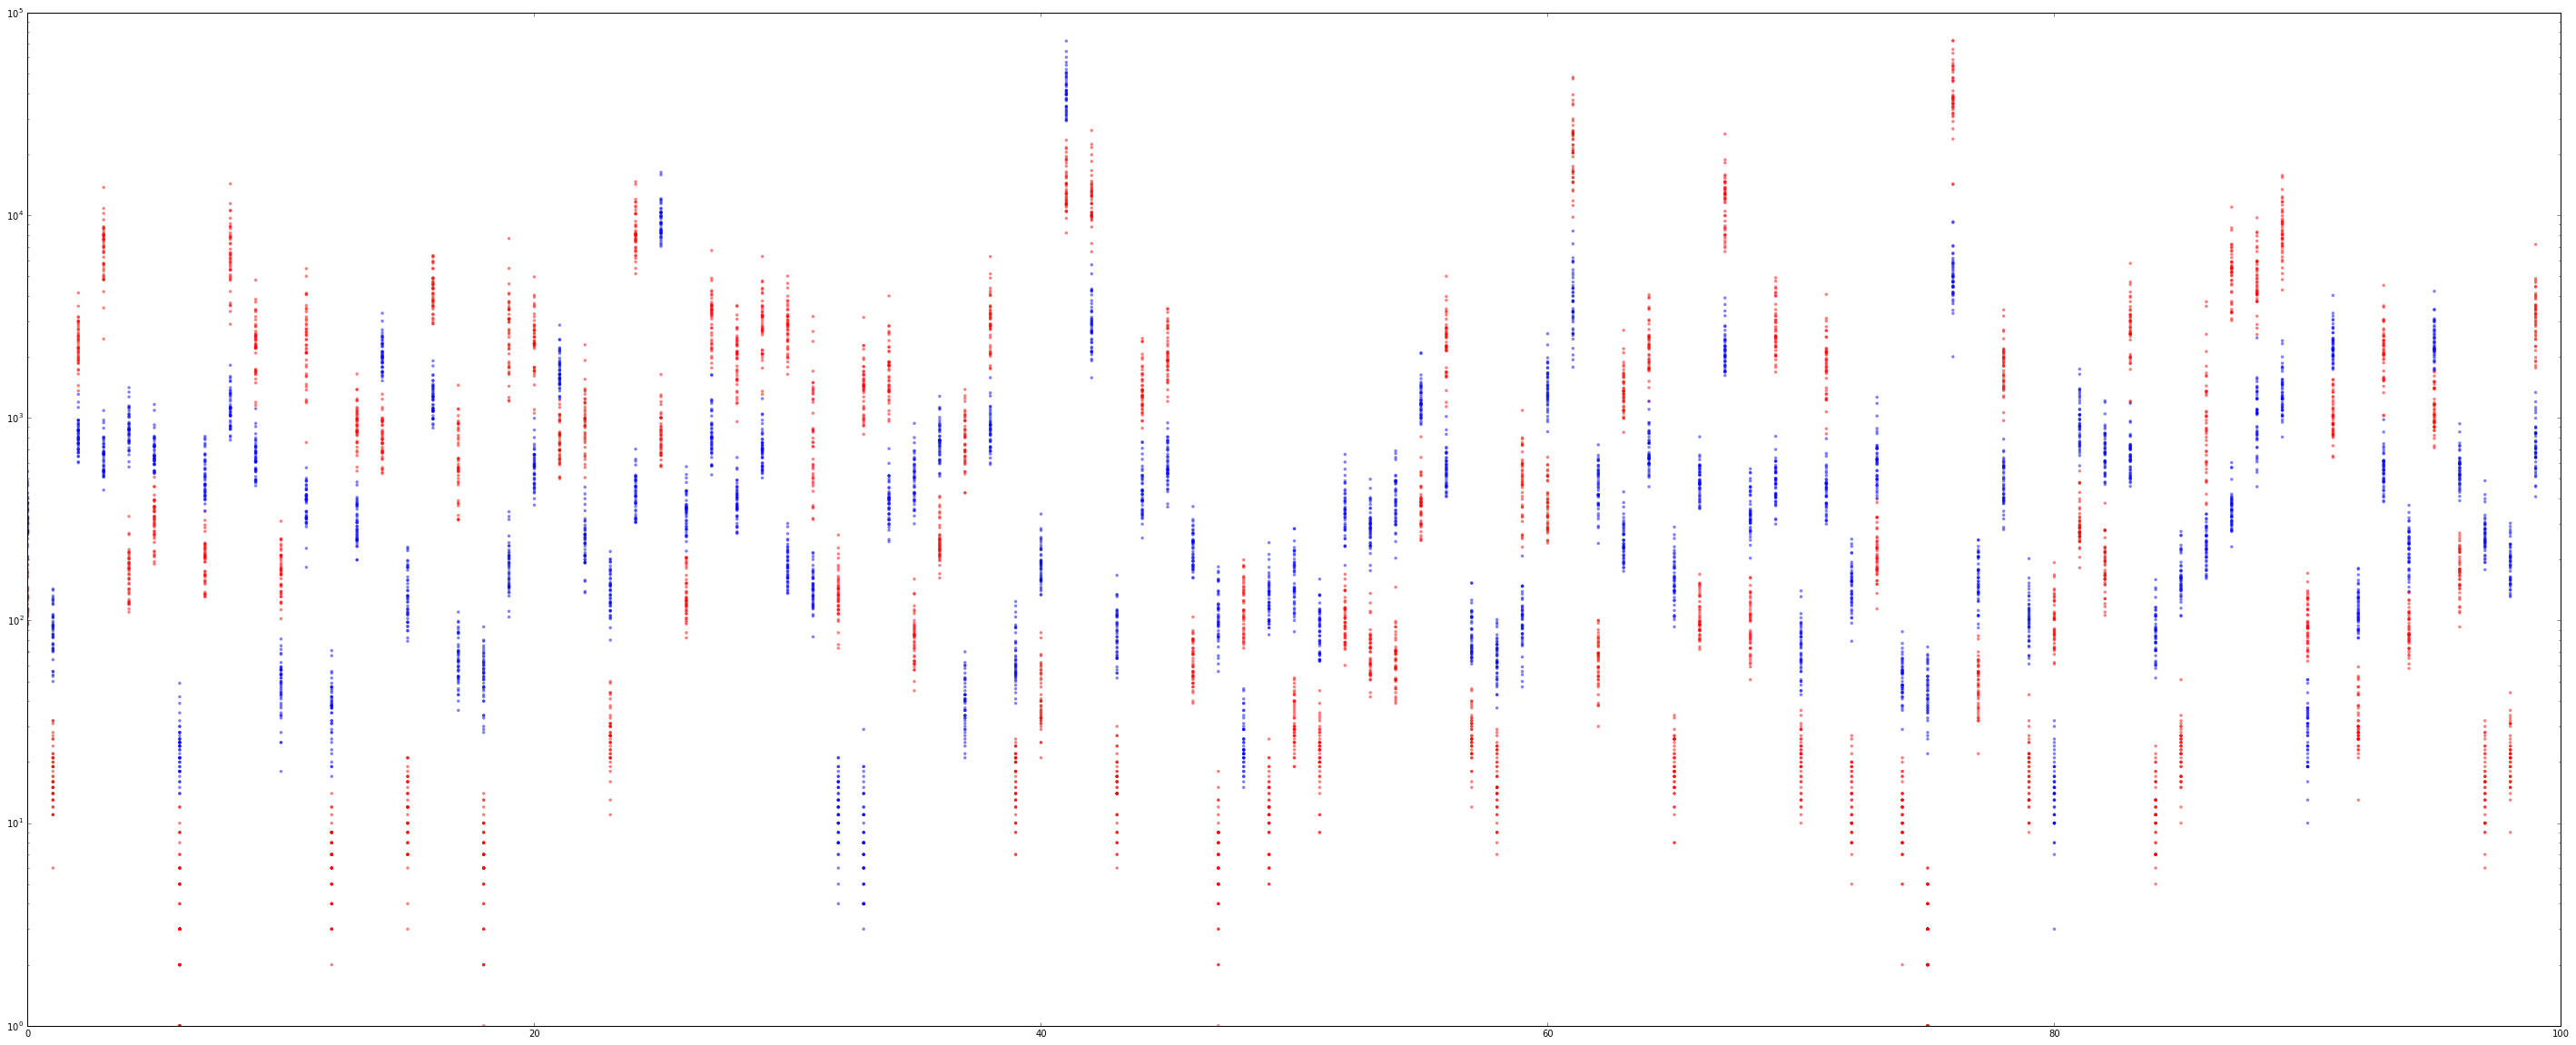

In [369]:
fig = plt.figure(figsize = (50,20))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,100)
ax.set_ylim(1,100000)
#ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(wt_x,wt,s=12,alpha=.5,c='r',edgecolor='none')
ax.scatter(snf2_x,snf2,s=12,alpha=.5,c='b',edgecolor='none')

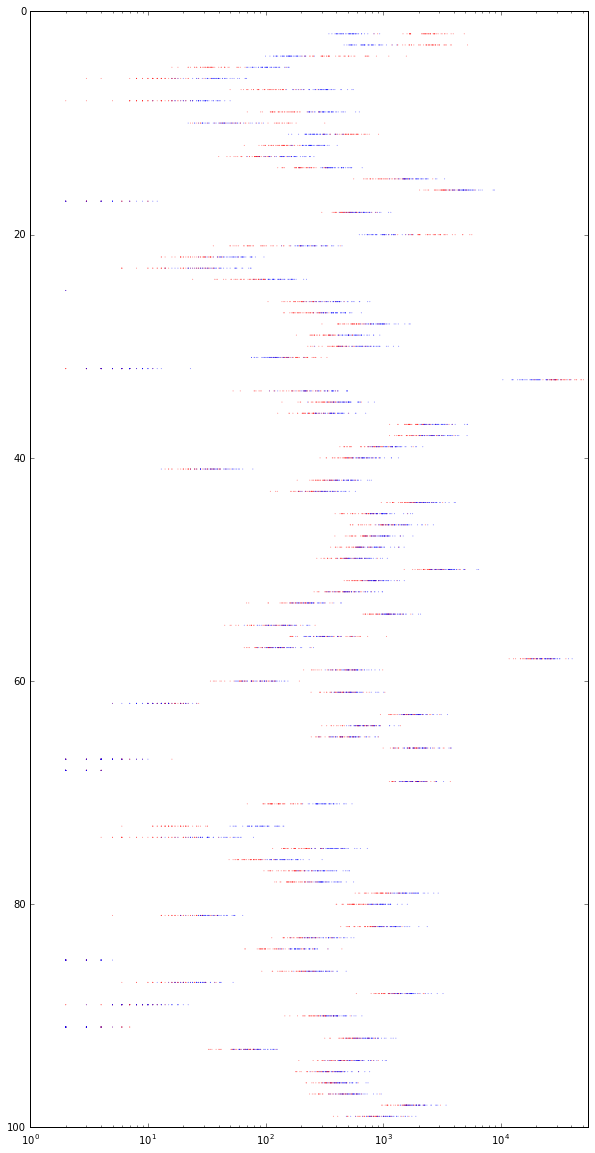

In [383]:
# Sort based on difference in means and plot top candidates

aved = {}

for index, row in df.iterrows():
    snf2 = row['Snf2_ave']
    wt = row['WT_ave']
    aved[index] = abs(wt-snf2)/(wt+snf2)
    
aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

snf2_ind = []
snf2 = []
wt_ind = [] 
wt = []

disp = 100

for i,t in enumerate(aveds[0:disp]):
    for c in colnames_snf2:
        snf2_ind.append(i+1)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,20))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + snf2))
ax.set_ylim(disp,0)
ax.set_xscale("log", nonposx='clip')
ax.scatter(wt,wt_ind,s=1,alpha=.5,c='r',edgecolor='none')
ax.scatter(snf2,snf2_ind,s=1,alpha=.5,c='b',edgecolor='none')

In [379]:
wt_ind

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


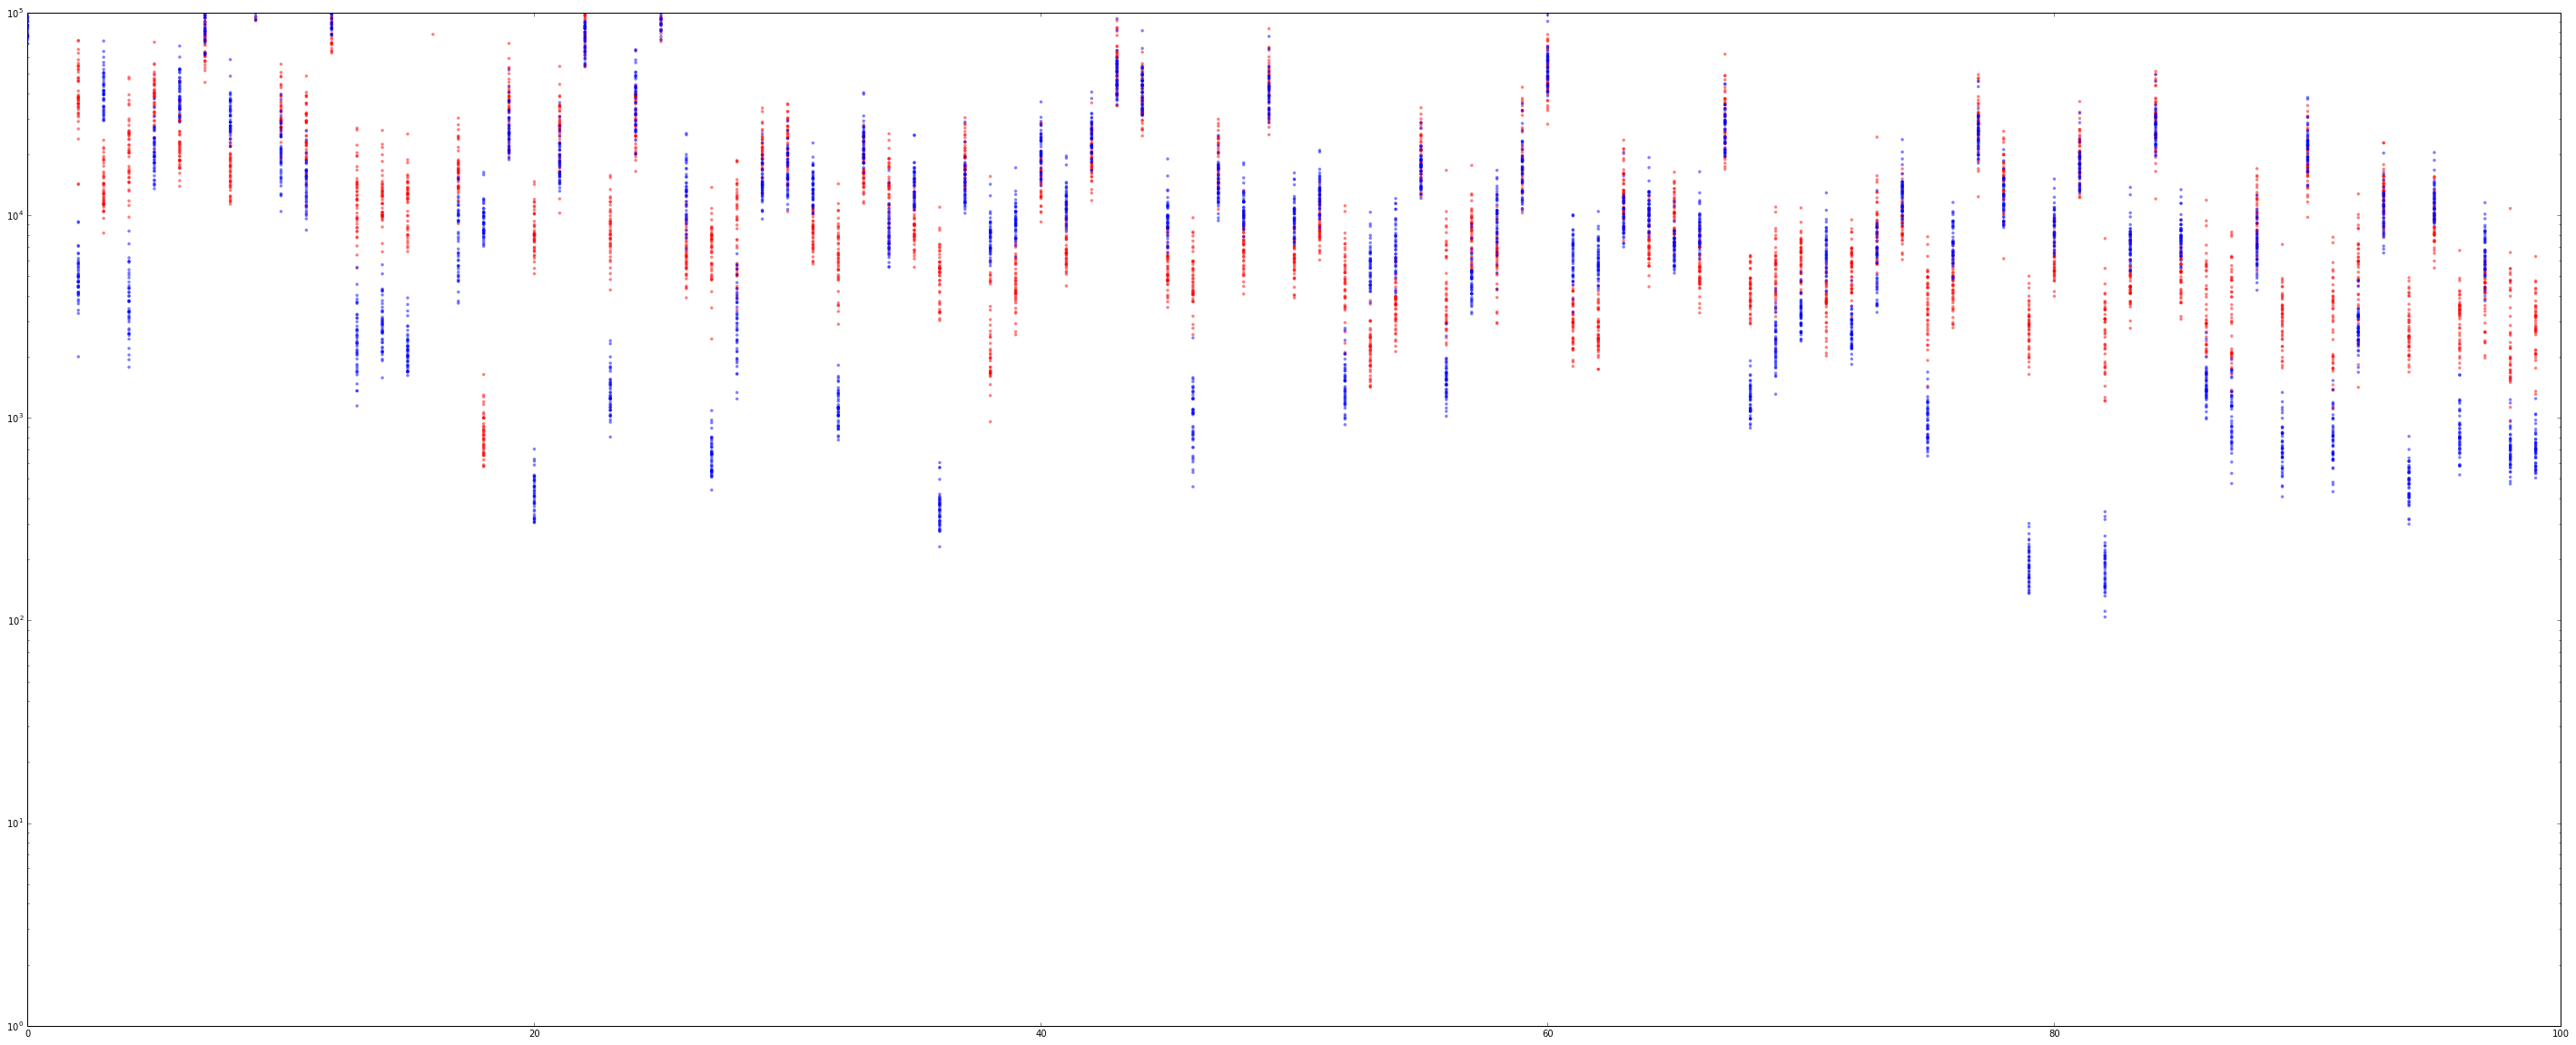

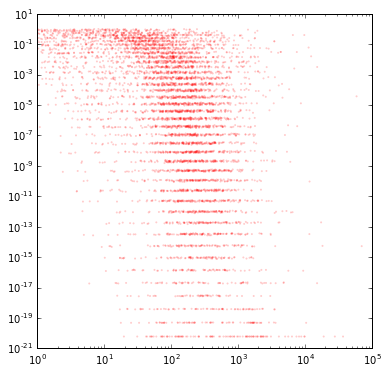

In [373]:
x = []
y = []

for r in aved.keys():
    x.append(aved[r])
    y.append(ksv[r])

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,100000)
#ax.set_ylim(1,100000)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x,y,s=4,alpha=.2,c='r',edgecolor='none')

In [214]:
norm_lsq = {}

c1 = 'ave'

for c in colnames:
    x = np.log10(df[c1][(df[c1] > 1) & (df[c] > 1)])
    y = np.log10(df[c][(df[c1] > 1) & (df[c] > 1)])

    x = x[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x, y)
    norm_lsq[c] = a
    df[c + "_nlsq"] = df[c] / a

    print (c,a)

Snf2_rep01 [ 1.04444477]
Snf2_rep02 [ 1.00627282]
Snf2_rep03 [ 1.0051327]
Snf2_rep04 [ 1.04991147]
Snf2_rep05 [ 0.97249915]
Snf2_rep07 [ 1.07610675]
Snf2_rep08 [ 0.99114796]
Snf2_rep09 [ 1.03140041]
Snf2_rep10 [ 0.98846059]
Snf2_rep11 [ 1.02149829]
Snf2_rep12 [ 0.98901561]
Snf2_rep14 [ 1.03091087]
Snf2_rep15 [ 0.98117946]
Snf2_rep16 [ 1.02687242]
Snf2_rep17 [ 1.0323011]
Snf2_rep18 [ 1.01078036]
Snf2_rep19 [ 0.98028039]
Snf2_rep20 [ 1.01347506]
Snf2_rep21 [ 1.02239679]
Snf2_rep22 [ 0.972917]
Snf2_rep23 [ 0.99308885]
Snf2_rep24 [ 1.07323157]
Snf2_rep25 [ 0.98347702]
Snf2_rep26 [ 1.03438859]
Snf2_rep27 [ 0.96442731]
Snf2_rep28 [ 0.9888207]
Snf2_rep29 [ 1.00313935]
Snf2_rep30 [ 0.98471287]
Snf2_rep31 [ 0.97395205]
Snf2_rep32 [ 1.02948098]
Snf2_rep33 [ 1.06336872]
Snf2_rep34 [ 1.01385759]
Snf2_rep36 [ 0.99352188]
Snf2_rep37 [ 1.00562154]
Snf2_rep38 [ 0.99335468]
Snf2_rep39 [ 1.09810108]
Snf2_rep40 [ 1.00450338]
Snf2_rep41 [ 1.0273395]
Snf2_rep42 [ 0.96853074]
Snf2_rep43 [ 1.02433865]
Snf2_r

In [221]:
norm_lsq = {}

c1 = 'ave'

for c in colnames:
    x = np.log10(df[c1][(df[c1] > 1) & (df[c] > 1)])
    y = np.log10(df[c + "_nlsq"][(df[c1] > 1) & (df[c] > 1)])

    x = x[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x, y)
    print (c,a)

Snf2_rep01 [ 1.03768355]
Snf2_rep02 [ 1.00530139]
Snf2_rep03 [ 1.00433722]
Snf2_rep04 [ 1.04233815]
Snf2_rep05 [ 0.97683102]
Snf2_rep07 [ 1.06470087]
Snf2_rep08 [ 0.99252884]
Snf2_rep09 [ 1.02659475]
Snf2_rep10 [ 0.99026271]
Snf2_rep11 [ 1.01819242]
Snf2_rep12 [ 0.99073239]
Snf2_rep14 [ 1.02617846]
Snf2_rep15 [ 0.98412957]
Snf2_rep16 [ 1.02275048]
Snf2_rep17 [ 1.02735962]
Snf2_rep18 [ 1.00911379]
Snf2_rep19 [ 0.98337438]
Snf2_rep20 [ 1.011395]
Snf2_rep21 [ 1.01895463]
Snf2_rep22 [ 0.97718189]
Snf2_rep23 [ 0.99416658]
Snf2_rep24 [ 1.06224417]
Snf2_rep25 [ 0.98606275]
Snf2_rep26 [ 1.02913222]
Snf2_rep27 [ 0.97005142]
Snf2_rep28 [ 0.9905675]
Snf2_rep29 [ 1.00265212]
Snf2_rep30 [ 0.9871065]
Snf2_rep31 [ 0.97804733]
Snf2_rep32 [ 1.02496444]
Snf2_rep33 [ 1.05381627]
Snf2_rep34 [ 1.01171859]
Snf2_rep36 [ 0.99453088]
Snf2_rep37 [ 1.00475025]
Snf2_rep38 [ 0.99439059]
Snf2_rep39 [ 1.08354899]
Snf2_rep40 [ 1.00380529]
Snf2_rep41 [ 1.02314765]
Snf2_rep42 [ 0.97349443]
Snf2_rep43 [ 1.02060129]
Snf2

In [ ]:
norm_lsq = {}

c1 = 'ave'

for c in colnames:
    x = np.log10(df[c1][(df[c1] > 1) & (df[c] > 1)])
    y = np.log10(df[c][(df[c1] > 1) & (df[c] > 1)])

    x = x[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x, y)
    norm_lsq[c] = a

    print (c,a)

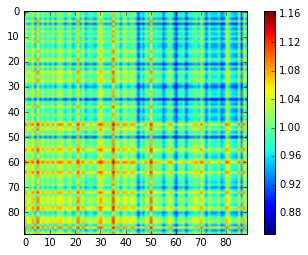

In [219]:
l = len(colnames)

corrdata = np.zeros((l,l))

for i1, c1 in enumerate(colnames):
    d = []
    for i2, c2 in enumerate(colnames):
        x = np.log10(df[c1 + "_nlsq"][(df[c1] > 1) & (df[c2] > 1)]) 
        y = np.log10(df[c2 + "_nlsq"][(df[c1] > 1) & (df[c2] > 1)]) 

        x = x[:,np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, y)

        corrdata[i1][i2] = a
plt.imshow(corrdata)
plt.colorbar()

In [239]:
# sort genes by average value
aves = []
for gene, row in df.iterrows():
    if row['ave'] > 5:
        aves.append((gene,row['ave']))
    
aves = sorted(aves,key = lambda x: x[1])


In [246]:
df['ave']

Gene
YAL001C        533.784722
YAL002W        480.939236
YAL003W       9233.585069
YAL004W          0.000000
YAL005C      12410.203125
YAL007C       1071.166667
YAL008W        437.187500
YAL009W        346.817708
YAL010C        331.243056
YAL011W        416.111111
YAL012W       5747.470486
YAL013W       1238.246528
YAL014C       1135.578125
YAL015C        472.071181
YAL016C-A       24.243056
YAL016C-B       50.059028
YAL016W       1659.111111
YAL017W       1158.157986
YAL018C          2.506944
YAL019W        664.946181
YAL019W-A        0.918403
YAL020C        464.237847
YAL021C       1151.526042
YAL022C       1087.986111
YAL023C       3722.258681
YAL024C        251.112847
YAL025C        809.248264
YAL026C        873.503472
YAL026C-A       21.902778
YAL027W        239.182292
                 ...     
YPR176C        538.274306
YPR177C          0.074653
YPR178W        370.220486
YPR179C        340.973958
YPR180W        418.706597
YPR181C       3124.701389
YPR182W        647.211806
YPR183W

In [290]:
df.loc['YAL015C',colnames].var()

39315.93590398367

In [281]:
x = []
y = []

for i,t in enumerate(aves):
    a = float(df.at[t[0],'ave'])
    for c in colnames:
        x.append(a)
        v = float(df.at[t[0],c])/a
        y.append(v)

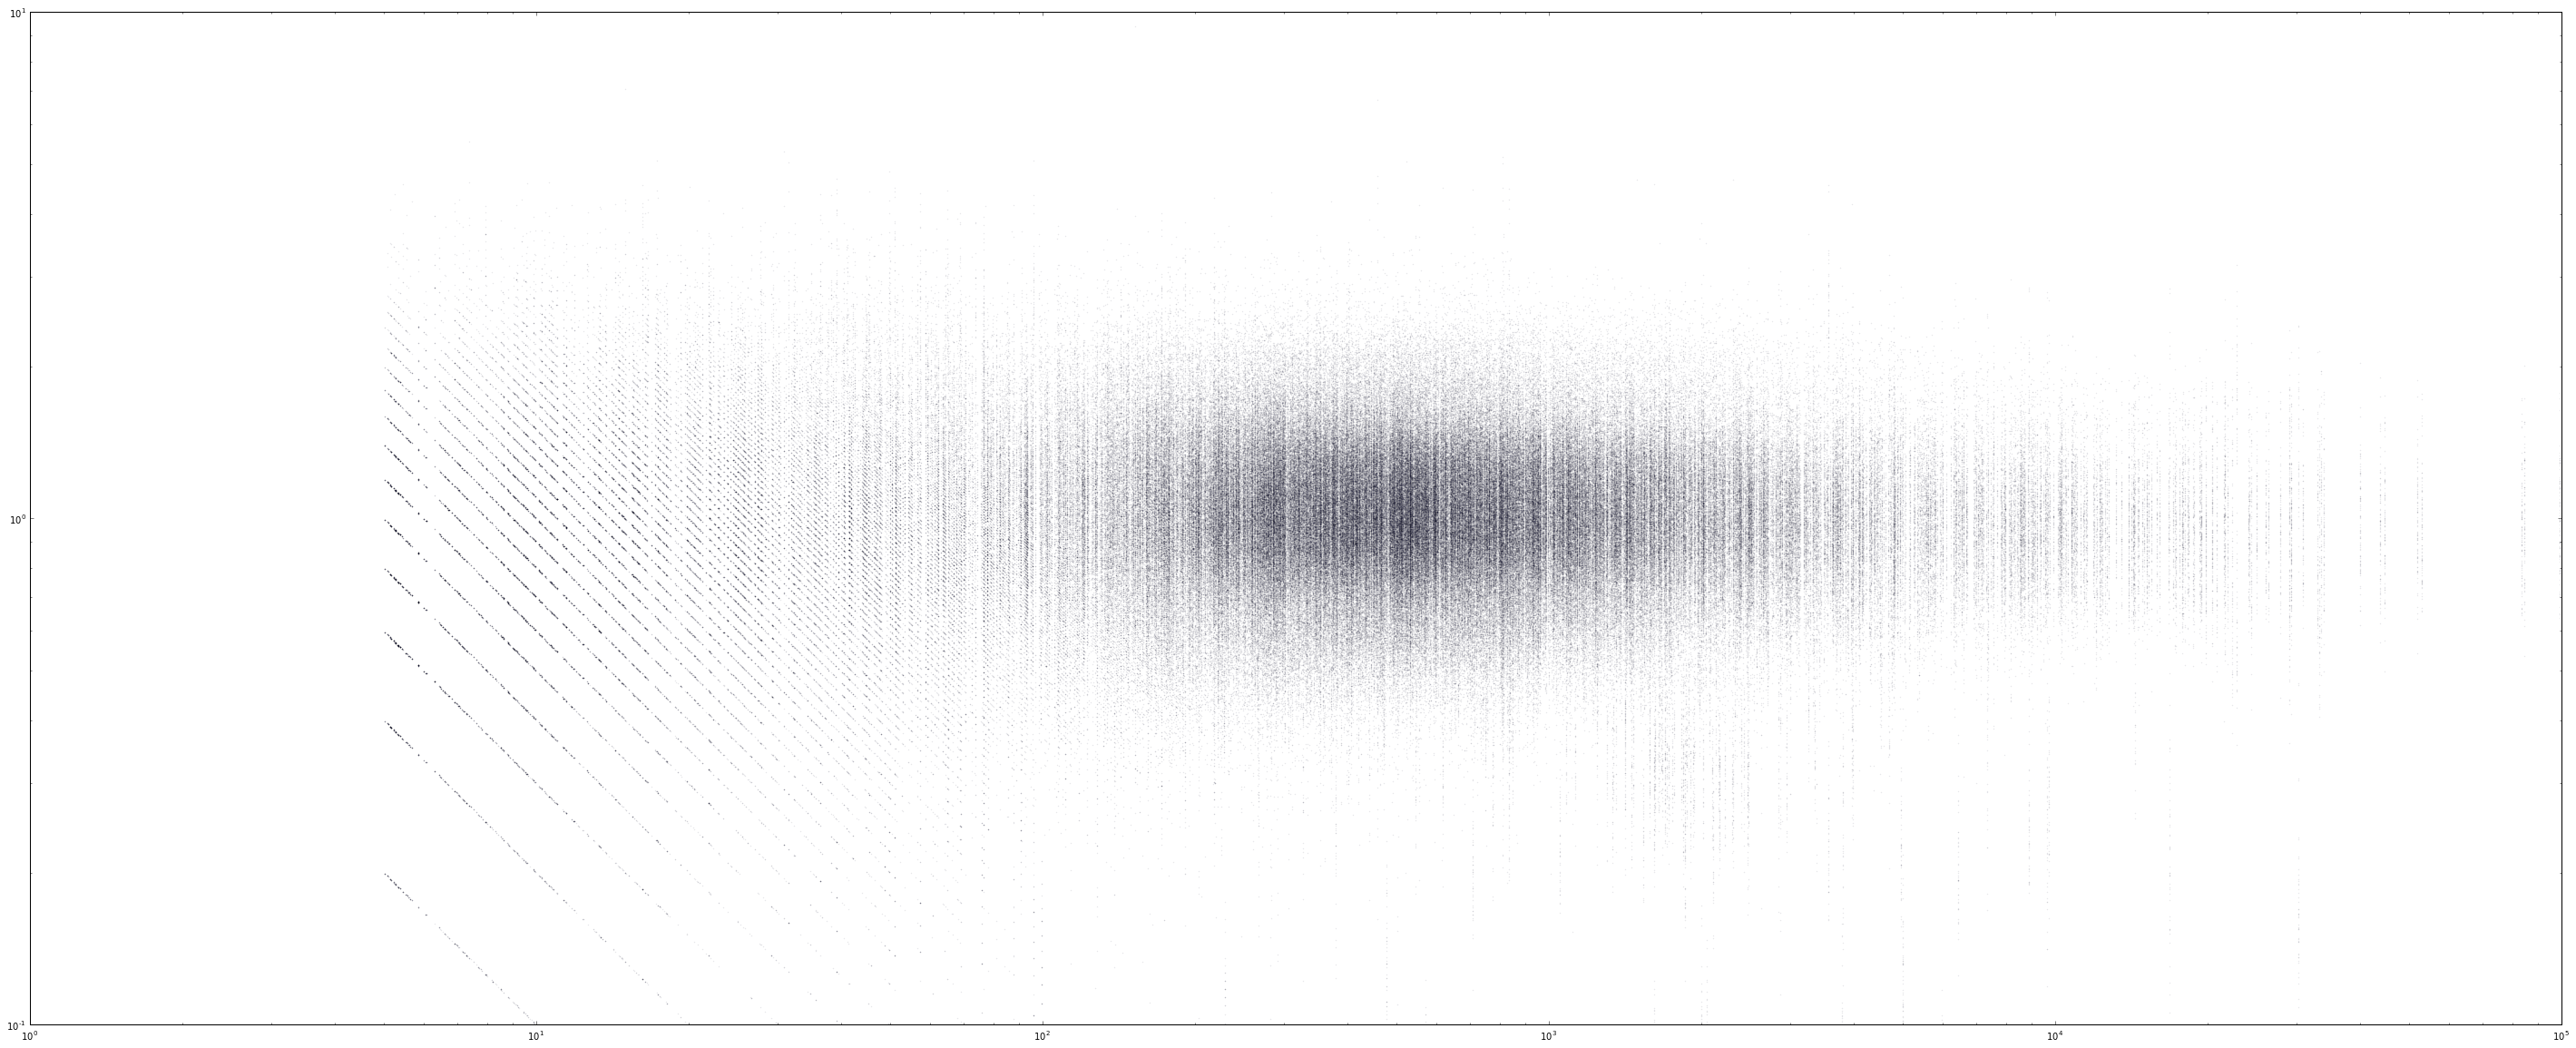

In [285]:
fig = plt.figure(figsize = (50,20))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,100000)
ax.set_ylim(.1,10)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x,y,s=.2,alpha=.1)

In [303]:
x = []
y = []
z = []

for i,t in enumerate(aves):
    d = df.loc[t[0],colnames_WT]
    x.append(d.mean())
    y.append(d.var())
    z.append(d.std())
    
x = np.array(x)
y = np.array(y)
z = np.array(z)

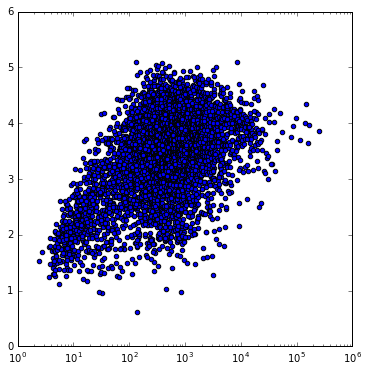

In [306]:
xx = x/z

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
#ax.set_xlim(1,100000)
#ax.set_ylim(.1,10)
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposx='clip')
ax.scatter(x,xx)

In [157]:
ksv = []
ent = []
for index, row in df.iterrows():
    snf2 = row[colnames_snf2[0:15]]
    wt = row[colnames_WT[0:15]]
    #ksv.append(ks_2samp(wt,snf2)[1])
    ent.append(entropy(snf2,wt))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

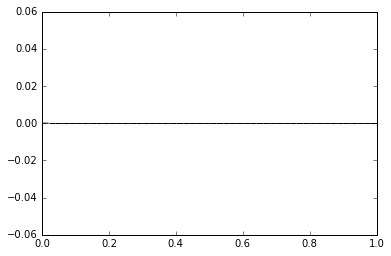

In [158]:
plt.hist(ksv,bins=50)

In [156]:
ent

[0.051703004102973044,
 0.056871655122536585,
 0.02520020513600274,
 inf,
 0.025625756758562018,
 0.028736135936862209,
 0.026161371912465266,
 0.03997831988498516,
 0.05076096878623873,
 0.045662160639882467,
 0.018619613599523816,
 0.023618839320399446,
 0.026228083804989949,
 0.027066506892825058,
 0.15937454455345448,
 0.15926956230805878,
 0.029768870291643795,
 0.046570738586347242,
 inf,
 0.081528639558512653,
 inf,
 0.024148331290109903,
 0.022893230723746306,
 0.030429970349933003,
 0.021268042850245673,
 0.048177513138841666,
 0.11774265958527262,
 0.045883470890365478,
 0.47087051507716621,
 0.03846315244806265,
 0.041693421210494921,
 0.051500782112627735,
 0.035540634316375018,
 0.040048341408356621,
 0.18233382527965447,
 0.019949583624450463,
 0.032754963169652589,
 0.042575414791189752,
 0.26650657331263283,
 0.035834205582567467,
 0.038170635159610493,
 0.06204383635379887,
 inf,
 0.56523652321820528,
 0.10092554384914665,
 0.031547127618106324,
 0.032280448952568791,
